# Autoregressive Moving Averages

ARMA models can be used on forecasting stationary datasets.

This section covers sales forecasting with <em>Autoregressive Moving Averages</em> (ARMA).

<strong>AR(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

while an <strong>MA(1)</strong> model follows the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = \mu + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

where $c$ is a constant, $\mu$ is the expectation of $y_{t}$ (often assumed to be zero), $\phi_1$ (phi-sub-one) is the AR lag coefficient, $\theta_1$ (theta-sub-one) is the MA lag coefficient, and $\varepsilon$ (epsilon) is white noise.

An <strong>ARMA(1,1)</strong> model therefore follows

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \theta_{1}\varepsilon_{t-1} + \varepsilon_{t}$

Above is a general trend behind the mathematical formula for the ARMA model, but we shall perform a test to know what order of ARMA to be used for out data.

## Standard libraries import 

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#loading ARMA forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tools.eval_measures import mse, rmse, meanabs

%matplotlib inline

## Automating the augmented Dickey-Fuller Test
This code can be reusable for performing augmented Dickey-Fuller Test, if an incoming time series is stationary or not.

In [2]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [3]:
#loading Sales dataset
dataset = pd.read_csv('sales.txt', delimiter = ';',index_col='retailweek',parse_dates=True )
dataset.head(5)

,country,article,sales,regular_price,current_price,ratio,promo1,promo2
retailweek,,,,,,,,
2014-12-28,Germany,AA1821,62,31.95,25.95,0.812207,1,0
2015-01-04,Germany,AA1821,29,31.95,22.95,0.718310,0,0
2015-01-11,Germany,AA1821,58,31.95,28.95,0.906103,0,0
2015-01-18,Germany,AA1821,49,31.95,29.95,0.937402,0,0
2015-01-25,Germany,AA1821,883,31.95,24.95,0.780908,0,0


## Combining same retailweeks and adding it's respecttive sales values

In [4]:
dataset_unique_week = pd.DataFrame(data= dataset.groupby('retailweek').sum())
dataset_unique_week.index.freq = 'W'
dataset_unique_week.head()


,sales,regular_price,current_price,ratio,promo1,promo2
retailweek,,,,,,
2014-12-28,67578,34834.9,21260.9,405.285245,662,0
2015-01-04,24676,34834.9,22880.9,440.971589,0,0
2015-01-11,26929,34834.9,24580.9,470.672012,0,0
2015-01-18,20912,34834.9,25715.9,488.332017,0,0
2015-01-25,22109,34834.9,26950.9,515.169986,0,103


## Resampling datetime index to monthly data for monthly forecast (optional)

In [5]:
dataset_unique_month = dataset_unique_week.resample(rule='M').mean()
dataset_unique_month.head()


,sales,regular_price,current_price,ratio,promo1,promo2
retailweek,,,,,,
2014-12-31,67578.0,34834.9,21260.90,405.285245,662.0,0.00
2015-01-31,23656.5,34834.9,25032.15,478.786401,0.0,25.75
2015-02-28,19830.0,34834.9,25889.65,496.946171,0.0,0.00
2015-03-31,31878.8,34834.9,19400.30,371.006995,0.0,0.00
2015-04-30,52082.5,34834.9,12906.65,250.413231,0.0,0.00


### Running the augmented Dickey-Fuller Test to confirm stationarity

In [6]:
adf_test(dataset_unique_week['sales'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.853434e+00
p-value                 3.545209e-07
# lags used             1.200000e+01
# observations          1.100000e+02
critical value (1%)    -3.491245e+00
critical value (5%)    -2.888195e+00
critical value (10%)   -2.580988e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Determining the (p,q) ARMA Orders
This will give us the $p$ and $q$ value recommendations for this dataset.

In [7]:
arma_order_select_ic(dataset_unique_week['sales'])

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


{'bic':              0            1            2
 0  2710.163305  2654.716932  2640.082673
 1  2618.089852  2622.635566  2627.443838
 2  2622.636240  2627.447384          NaN
 3  2627.452589  2610.194437          NaN
 4  2631.552570  2607.964397  2597.260368, 'bic_min_order': (4, 2)}

## Ploting the sales data from the dataset

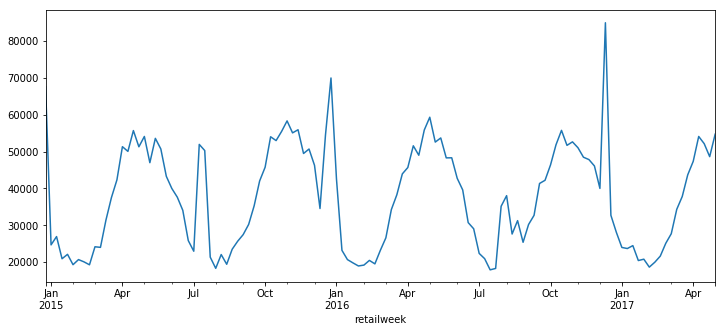

In [8]:
dataset_unique_week['sales'].plot(figsize=(12,5));

### Splitting the data into train/test sets
As a general rule, we should set the length of your test set equal to your intended forecast size. For this dataset I will attempted 6-months forecast.

In [9]:
train = dataset_unique_week.iloc[:97]
test = dataset_unique_week.iloc[97:]

In [10]:
#train.describe()
#test.describe()

### Fitting an ARMA(p,q) Model

In [11]:
#help(ARMA) 

In [12]:
model = ARMA(train['sales'],order=(4,2))
results = model.fit()
results.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  sales   No. Observations:                   97
Model:                     ARMA(4, 2)   Log Likelihood                -997.662
Method:                       css-mle   S.D. of innovations           6826.783
Date:                Wed, 22 May 2019   AIC                           2011.325
Time:                        15:33:43   BIC                           2031.923
Sample:                    12-28-2014   HQIC                          2019.654
                         - 10-30-2016                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         3.86e+04    146.982    262.636      0.000    3.83e+04    3.89e+04
ar.L1.sales     2.2942      0.158     14.524      0.000       1.985       2.604
ar.L2.sales    -2.0405      0.311     -6.560      0.000      -2.650      -1.431
ar.L3.sales     1.0182      0.266      3.827      0.000       0.497       1.540
ar.L4.sales    -0.3306      0.120     -2.756      0.007      -0.566      -0.095
ma.L1.sales    -1.6836      0.149    -11.294      0.000      -1.976      -1.391
ma.L2.sales     0.6836      0.146      4.669      0.000       0.397       0.971
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9807           -0.2493j            1.0119           -0.0396
AR.2            0.9807           +0.2493j            1.0119            0.0396
AR.3            0.5594           -1.6253j            1.7189           -0.1972
AR.4            0.5594           +1.6253j            1.7189            0.1972
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.4628           +0.0000j            1.4628            0.0000
-----------------------------------------------------------------------------
"""

### Predicting 6 month's values to later compare it with test sets

In [13]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

### Plotting predictions against known test values

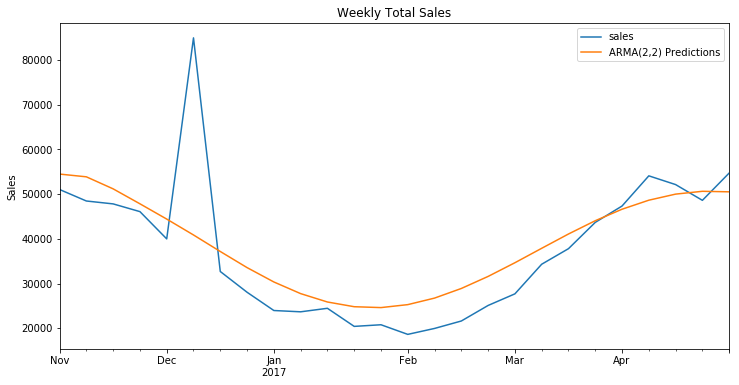

In [14]:
title = 'Weekly Total Sales'
ylabel='Sales'
xlabel='' # we don't really need a label here

ax = test['sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [15]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['sales'], predictions)
print(f'ARMA(4,2) RMSE Error: {error:11.10}')

ARMA(4,2) RMSE Error: 9756.246145


Since our dataset exhibited no trend or seasonal component, this prediction makes sense.

### Evaluating the Model

In [16]:
error = rmse(test['sales'], predictions)
print(f'ARMA(4,2) RMSE Error: {error:11.10}')

ARMA(4,2) RMSE Error: 9756.246145


### Retraining the model on the full data, and then forecasting the future

In [30]:
model = ARMA(dataset_unique_week['sales'],order=(4,2))
results = model.fit()
fcast = results.predict(len(dataset_unique_week),len(dataset_unique_week)+6).rename('ARMA(4,2) Forecast')

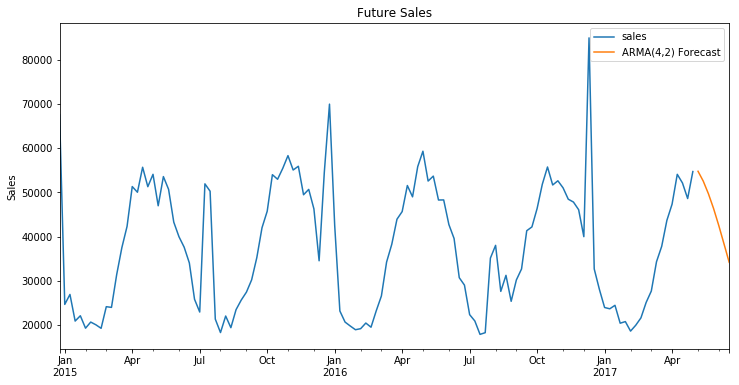

In [32]:
title = 'Future Sales'
ylabel='Sales'
xlabel='' # we don't really need a label here

ax = dataset_unique_week['sales'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);